# Checking TF Activity of Developing Fetal Cortex using Knowledge Base and Transcriptomics-derived GRNs with `decoupler`

## Introduction

In this part of our hands-on session, we will attempt to estimate Transcription Factor Activity from [a high-quality single-cell RNASeq Transcriptomic Data of Human Neocortical Development during Mid-gestation](https://www.sciencedirect.com/science/article/pii/S0896627319305616?via%3Dihub) to see whether regulons inferred from their own transcriptome and regulons derived from knowledge base can be used to estimate TF Activity.

We will then check whether these regulons can be used on another dataset of cortical organoids, the notoriuos [Trujillio dataset](https://www.sciencedirect.com/science/article/pii/S1934590919303376), a dataset made of around 34k cells. 

To rest for TF Activity, we will use [decoupler](https://saezlab.github.io/decoupleR/) a library that incliudes several methods for testing the TF Activity, from [VIPER](https://bioconductor.org/packages/devel/bioc/vignettes/viper/inst/doc/viper.pdf) to [AUCELL](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html) (Already implemented in SCENIC). 


We will then explore the activity of these regulons and use the activity to re-cluster cells in these two datasets.

### Load libraries and define general variables

In [1]:
import os
import sys

import decoupler as dc
import scanpy as sc


import numpy as np
import pandas as pd
import igraph as ig

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Jupyter  multiple line output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# extend pandas pd.head() to show the first 100 lines
pd.set_option('display.max_rows', 100)

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
results_dir = os.path.join(os.getcwd(), 'results')

## Reload Human Cortical Development Dataset

A brief table summarizing the cluster annotation as provided by the authors
| Acronym |                Full Name                |
|:-------:|:---------------------------------------:|
|  PgG2M  |           Progenitor G2M Phase          |
|   PgS   |            Progenitor S Phase           |
|   oRG   |            outer Radial Glia            |
|   vRG   |           ventral Radial Glia           |
|    IP   |         Intermediate Progenitors        |
|   ExN   |       Excitatory Migratory Neurons      |
|   ExM   |        Excitatory Mature Neurons        |
|  ExM-U  | Excitatory Mature Neurons - Upper Layer |
|  ExDp1  |      Excitatory Deep Layer Neurons      |
|  ExDp2  |      Excitatory Deep Layer Neurons      |
|   Mic   |                Microglia                |
|   OPC   |          Outer Progenitor Cells         |
|  InCGE  |             Interneurons CGE            |
|  InMGE  |             Interneurons MGE            |
|   Per   |                Pericytes                |
|   End   |            Endothelial Cells            |

AnnData object with n_obs × n_vars = 33976 × 3851
    obs: 'Cluster', 'Subcluster', 'Donor', 'Layer', 'Gestation_week', 'Index', 'Library', 'Number_genes_detected', 'Number_UMI', 'Percentage_mitochondrial', 'S_phase_score', 'G2M_phase_score', 'Phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cluster_colors', 'Donor_colors', 'Library_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Cluster Subcluster Donor Layer  Gestation_week Index Library  \
Barcodes                                                                    
CGCCGTACGTTC     ExM      ExM_1   368    CP              17  N701   Plath   
TCAGCGTGGACA     End      End_0   368    CP              17  N701   Plath   
TATGCTTATGTC     ExM      ExM_1   368    CP              17  N701   Plath   
TCAGCGTGGACT     End      End_3   368    CP              17  N701   Plath   
GATTACCTTATA     ExM      ExM_1   368    CP              17  N701   Plath   

              Number_genes_detected  Number_UMI  Percentage_mitochondrial  \
Barcodes                                                                    
CGCCGTACGTTC                   3056        9036                      3.18   
TCAGCGTGGACA                   3144        7280                      3.46   
TATGCTTATGTC                   2778        7908                      3.63   
TCAGCGTGGACT                   2936        6687                      3.14   
GATTACCTTATA                   2586        7111                      4.21   

              ...  G2M_phase_score  Phase n_genes_by_counts  total_counts  \
Barcodes      ...                                                           
CGCCGTACGTTC  ...            -0.12     G1              3055        9035.0   
TCAGCGTGGACA  ...            -0.18     G1              3144        7280.0   
TATGCTTATGTC  ...            -0.22     G1              2778        7908.0   
TCAGCGTGGACT  ...            -0.21     G1              2935        6686.0   
GATTACCTTATA  ...            -0.16     G1              2585        7110.0   

              total_counts_mt  pct_counts_mt   S_score  G2M_score  phase  \
Barcodes                                                                   
CGCCGTACGTTC            287.0       3.176536 -0.070116  -0.055597     G1   
TCAGCGTGGACA            252.0       3.461539 -0.143634  -0.140365     G1   
TATGCTTATGTC            287.0       3.629236 -0.069978  -0.138964     G1   
TCAGCGTGGACT            210.0       3.140891 -0.108950  -0.135006     G1   
GATTACCTTATA            299.0       4.205345 -0.190435  -0.121703     G1   

             leiden  
Barcodes             
CGCCGTACGTTC      9  
TCAGCGTGGACA     11  
TATGCTTATGTC      9  
TCAGCGTGGACT     11  
GATTACCTTATA      9  

[5 rows x 21 columns]

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


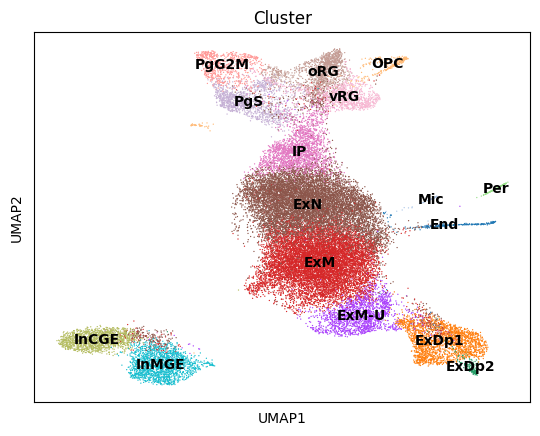

In [4]:
adata = sc.read_h5ad(os.path.join(data_dir, 'Polioudakis_2019.h5ad'))
adata
adata.obs.head()
sc.pl.umap(adata, color = 'Cluster', legend_loc='on data')

## Check the expression of Relevant TFs

Let's reload here the relevn tfs used in the first part of nthis lecture and check their expression inside the different clusters. Can we see an overall contribution of these regulons to the

In [5]:
fetal_brain_tfs = pd.read_csv(os.path.join(data_dir, 'Fetal_Brain_TFs.tsv'), sep = '\t')
fetal_brain_tfs

population      TF
0            Progenitor    PAX6
1            Progenitor     FOS
2            Progenitor    SOX2
3   Immature_Excitatory   EOMES
4   Immature_Excitatory    ETV2
5   Immature_Excitatory    ETV3
6   Immature_Excitatory    ETV4
7    Excitatory_Neurons  BCL11A
8    Excitatory_Neurons  BCL11B
9    Excitatory_Neurons    CUX1
10   Excitatory_Neurons    CUX2

TF that are present in the dataset:
PAX6	FOS	SOX2	EOMES	ETV2	ETV3	ETV4	BCL11A	BCL11B	CUX1	CUX2


/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


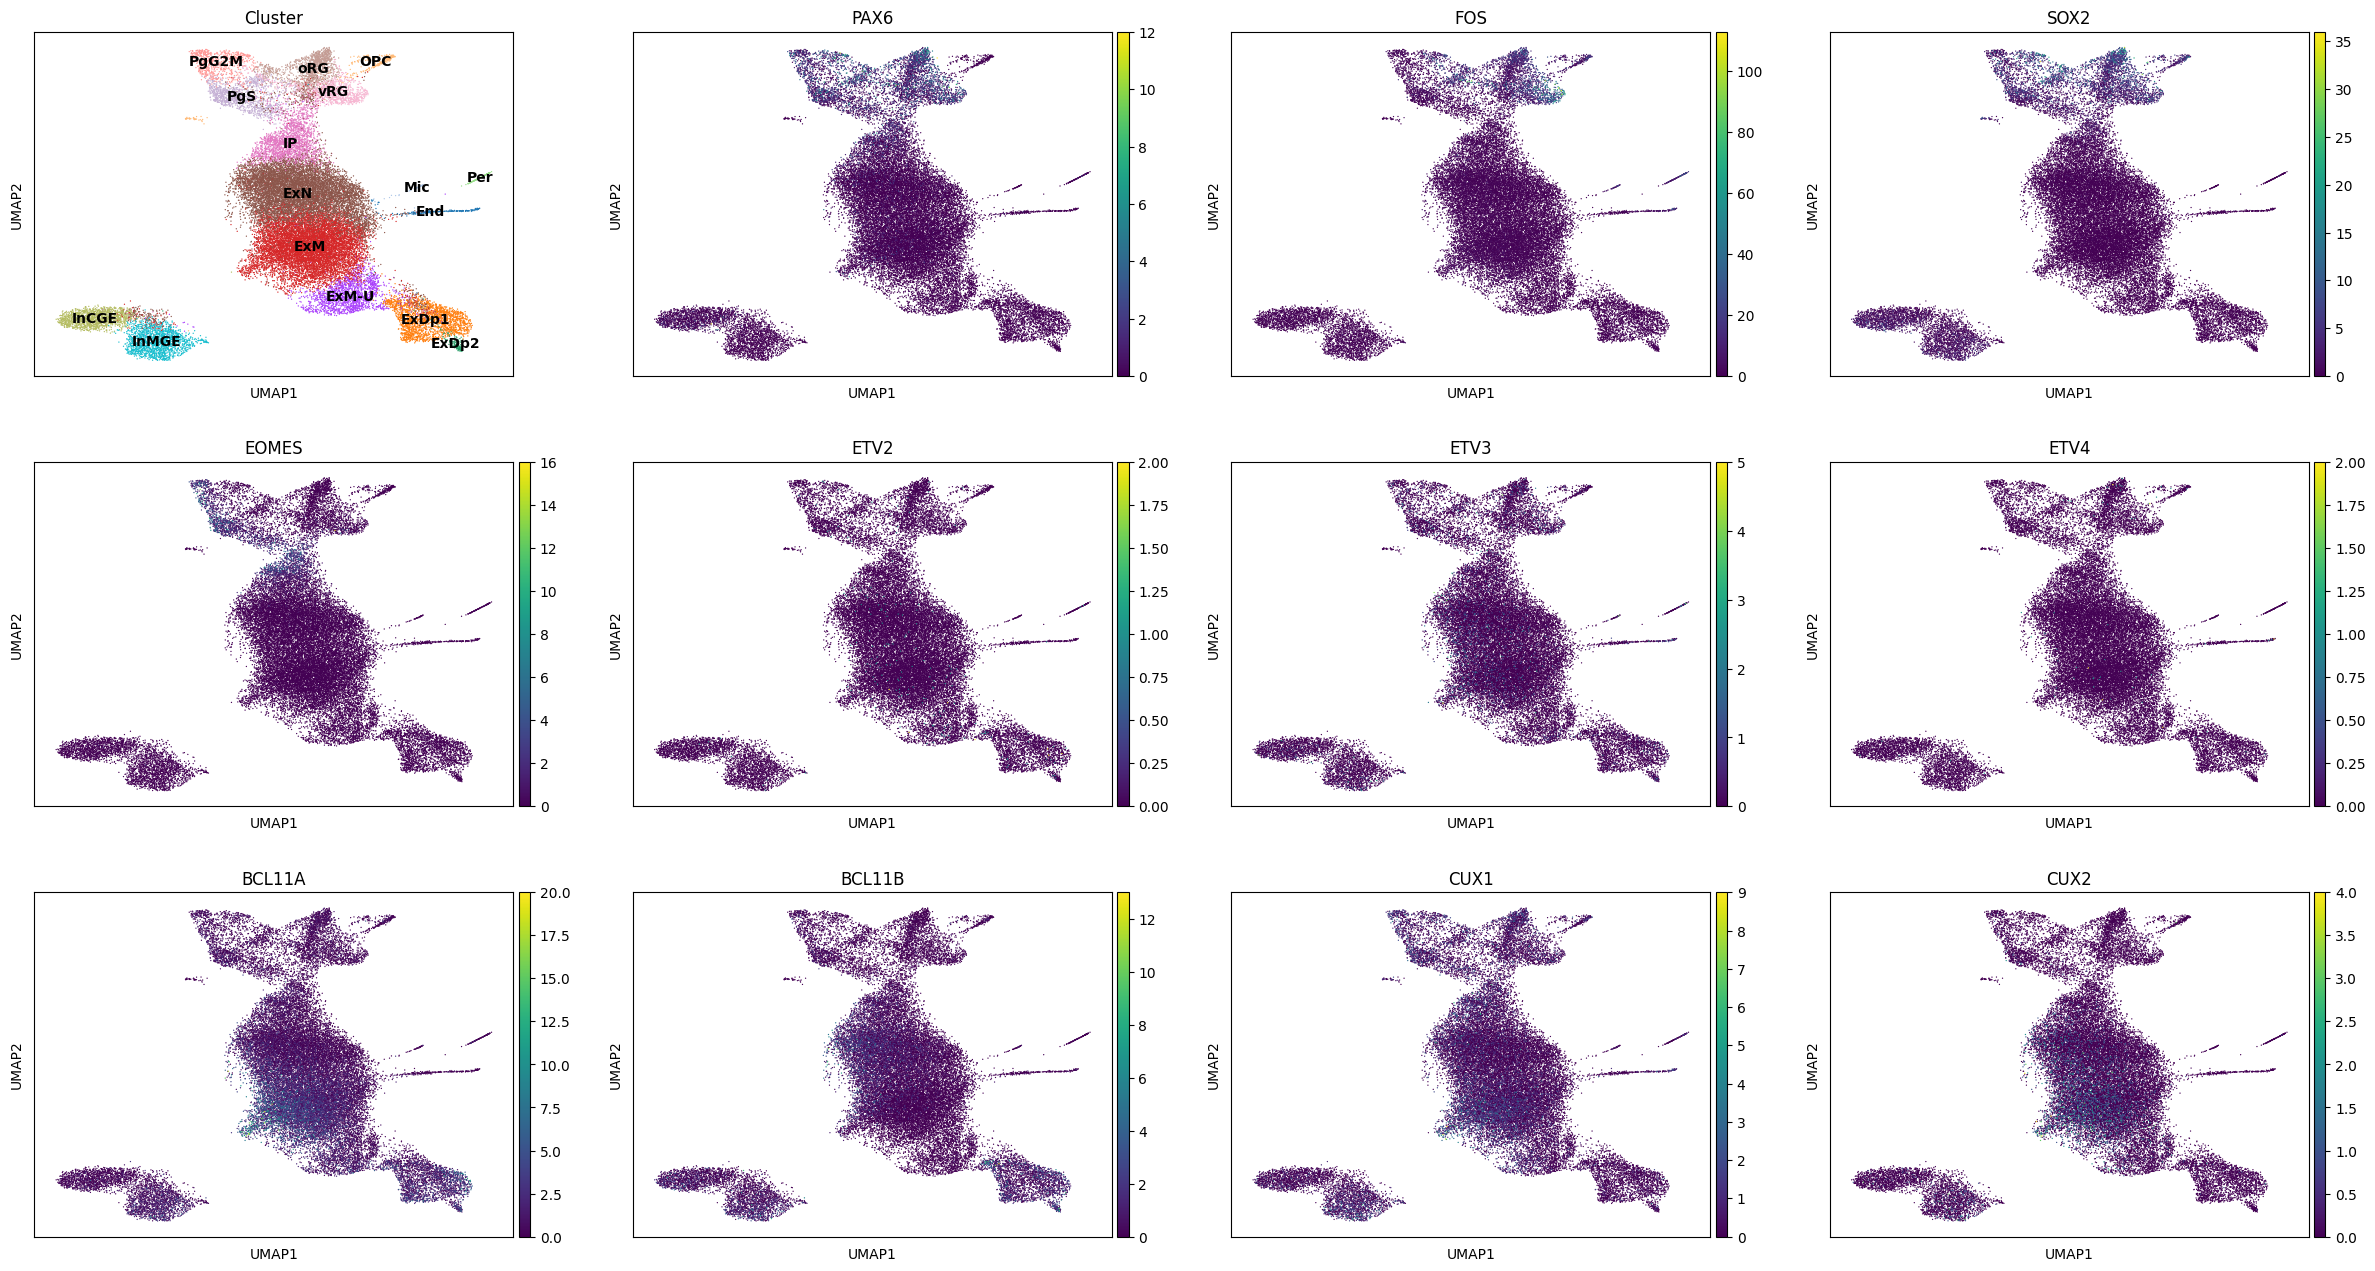

In [6]:
#adata.var_names
expressed_tfs = [x for x in fetal_brain_tfs['TF'] if x in adata.raw.var_names]
print('TF that are present in the dataset:\n{}'.format('\t'.join(expressed_tfs)))
sc.pl.umap(adata, color = ['Cluster'] + expressed_tfs, legend_loc = 'on data')

## IMPORTANT!! Convert the `anndata` to raw (lognorm counts) to use all features!

In [ ]:
adata = adata.raw.to_adata()

## Evaluate the difference in different methods to compute TF Activity

Here we use three  methods to test for the TF Activity: 

1. [VIPER ](https://decoupler-py.readthedocs.io/en/latest/generated/decoupler.run_viper.html)  using a pleiotropy corretions, hence lowering the TF Activity of each regulon by the number of common targets across regulons
2. [AUCELL](https://decoupler-py.readthedocs.io/en/latest/generated/decoupler.run_aucell.html#decoupler.run_aucell) as implemented in the SCENIC paper. This method requires a seed to resolve randomly ties in ranking TFs. **Note** AUCell is a *relative* measure, as it represent the proportion of abundance of targets of a regulon within a sample with respect to the other regulons. It **does not** require a weight.
3. [mlm](https://decoupler-py.readthedocs.io/en/latest/generated/decoupler.run_mlm.html#decoupler.run_mlm) fits a multivariate linear model in each cell, using the weights as covariate. The TF Activity is the t-value of the regulon

In [93]:
def run_decoupler(adata, regulons, reg_type, methods = ['viper', 'mlm', 'aucell']):
    if 'viper' in methods:
        print('Running VIPER')
        dc.run_viper(mat=adata, net=regulons, source = 'source', target='target', weight = 'weight', verbose=True, use_raw=False, pleiotropy = True, min_n = 3)
        adata.obsm['{}_viper_estimate'.format(reg_type)] = adata.obsm['viper_estimate'].copy()
        adata.obsm['{}_viper_pvals'.format(reg_type)] = adata.obsm['viper_pvals'].copy()
    if 'aucell' in methods:
        print('Running AUCell')
        dc.run_aucell(mat=adata, net=regulons, source = 'source', target='target', verbose=True, use_raw=False, min_n=3, seed = 100)
        adata.obsm['{}_aucell_estimate'.format(reg_type)] = adata.obsm['aucell_estimate'].copy()
    if 'mlm' in methods:
        print('Running MLM')
        dc.run_mlm(mat=adata, net=regulons, source = 'source', target='target', weight = 'weight', verbose=True, use_raw=False, min_n=3)
        adata.obsm['{}_mlm_estimate'.format(reg_type)] = adata.obsm['mlm_estimate'].copy()
        adata.obsm['{}_mlm_pvals'.format(reg_type)] = adata.obsm['mlm_pvals'].copy()
    print('done')
    return adata

### TF Activity of Knowledge Base derived regulons

Here we  make use of the `decoupler` package to evaluate the TF Activity. 

We first preprocess our knowledge base regulons to make it compliant with the standard

In [66]:
# we first reload the knowledge-base regulons and reparse it (pesky decoupler bug)
kb_regulons = pd.read_csv(os.path.join(data_dir, 'regulons_human.tsv'), sep = '\t')
kb_regulons.shape

#reparse the df columns to make it compliant to decoupler standards
kb_regulons = kb_regulons.iloc[:, :3]
kb_regulons.columns = ['source', 'target', 'weight']
kb_regulons.drop_duplicates(subset = ['source', 'target'], keep = 'first', inplace=True)
kb_regulons

print('Total Number of TFs:\t' , kb_regulons['source'].unique().shape[0])

(3912, 4)

source    target  weight
0       ADNP      CTCF      -1
1       ADNP    CTNNB1       1
2       ADNP  MAP1LC3B       1
3        AHR    CYP1A1       1
4        AHR    CYP1B1       1
...      ...       ...     ...
3907  ZNF462      PBX1      -1
3908  ZNF521      EBF1      -1
3909   ZNF76       TBP      -1
3910   ZNF76      TCP1       1
3911   ZNF91    FCGR3B      -1

[3911 rows x 3 columns]

Total Number of TFs:	 513


### TF Activity


In [68]:
adata_act = run_decoupler(adata, regulons = kb_regulons,  reg_type='kb')

Running VIPER
Running viper on mat with 33976 samples and 3851 targets for 74 sources.
Infering activities on 4 batches.


100%|██████████| 4/4 [00:19<00:00,  4.86s/it]


Computing pleiotropy correction.


100%|██████████| 33976/33976 [02:17<00:00, 247.28it/s]


Running AUCell
Running aucell on mat with 33976 samples and 3851 targets for 74 sources.
Running MLM
Running mlm on mat with 33976 samples and 3851 targets for 74 sources.


100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


done


Let's explore the different estimates

In [81]:
adata.obsm['kb_mlm_estimate']
adata.obsm['kb_aucell_estimate']
adata.obsm['kb_viper_estimate']

(33976, 74)

(33976, 74)

(33976, 74)

### Heatmap of TF Activities

We know check the mean TF Activity in each cluster by computing the mean of each TF Activity and then removing regulons whose standard deviation is greater than 0.5 across all cells. This parameter can be tuned: the regulons will be more, but their mean tf will be more or less equal in all cells.

Text(0.5, 0.98, 'kb_viper')

[Text(0.5, 0, 'FOXO1'),
 Text(1.5, 0, 'ETS1'),
 Text(2.5, 0, 'ETS2'),
 Text(3.5, 0, 'STAT1'),
 Text(4.5, 0, 'STAT5A'),
 Text(5.5, 0, 'TCF7L2'),
 Text(6.5, 0, 'ERG'),
 Text(7.5, 0, 'JUN'),
 Text(8.5, 0, 'MECP2'),
 Text(9.5, 0, 'SMAD3'),
 Text(10.5, 0, 'STAT3'),
 Text(11.5, 0, 'NFKB1'),
 Text(12.5, 0, 'STAT6'),
 Text(13.5, 0, 'MYC'),
 Text(14.5, 0, 'TFDP1'),
 Text(15.5, 0, 'SRF'),
 Text(16.5, 0, 'FOXA1'),
 Text(17.5, 0, 'DMTF1'),
 Text(18.5, 0, 'E2F4'),
 Text(19.5, 0, 'RBPJ'),
 Text(20.5, 0, 'KLF4'),
 Text(21.5, 0, 'SP1'),
 Text(22.5, 0, 'ESR1'),
 Text(23.5, 0, 'ATF2'),
 Text(24.5, 0, 'MITF'),
 Text(25.5, 0, 'FOS'),
 Text(26.5, 0, 'TCF4'),
 Text(27.5, 0, 'RELA'),
 Text(28.5, 0, 'SMAD4'),
 Text(29.5, 0, 'FOXO3'),
 Text(30.5, 0, 'E2F1'),
 Text(31.5, 0, 'GLI1'),
 Text(32.5, 0, 'TFAP4')]

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


kb_aucell_estimate cannot be aggregated around its mean/median


Text(0.5, 0.98, 'kb_mlm')

[Text(0.5, 0, 'E2F1'),
 Text(1.5, 0, 'MYC'),
 Text(2.5, 0, 'HLX'),
 Text(3.5, 0, 'AR'),
 Text(4.5, 0, 'SP1'),
 Text(5.5, 0, 'MECP2'),
 Text(6.5, 0, 'GLI1'),
 Text(7.5, 0, 'SRF'),
 Text(8.5, 0, 'TFAP2A'),
 Text(9.5, 0, 'NR1H2'),
 Text(10.5, 0, 'NANOG'),
 Text(11.5, 0, 'CLOCK'),
 Text(12.5, 0, 'RELA'),
 Text(13.5, 0, 'RORA'),
 Text(14.5, 0, 'LEF1'),
 Text(15.5, 0, 'TAL1'),
 Text(16.5, 0, 'TFAP4'),
 Text(17.5, 0, 'FOS'),
 Text(18.5, 0, 'TCF4'),
 Text(19.5, 0, 'ERG'),
 Text(20.5, 0, 'TCF7L2'),
 Text(21.5, 0, 'EGR1'),
 Text(22.5, 0, 'ETS1'),
 Text(23.5, 0, 'SMAD3'),
 Text(24.5, 0, 'ARNTL'),
 Text(25.5, 0, 'SP3'),
 Text(26.5, 0, 'NR1H3'),
 Text(27.5, 0, 'RBPJ'),
 Text(28.5, 0, 'PPARG'),
 Text(29.5, 0, 'JUN'),
 Text(30.5, 0, 'RUNX1'),
 Text(31.5, 0, 'ETS2'),
 Text(32.5, 0, 'STAT3'),
 Text(33.5, 0, 'DMTF1'),
 Text(34.5, 0, 'USF1'),
 Text(35.5, 0, 'NFKB1'),
 Text(36.5, 0, 'CEBPA'),
 Text(37.5, 0, 'CEBPB'),
 Text(38.5, 0, 'SMAD4'),
 Text(39.5, 0, 'ATF2'),
 Text(40.5, 0, 'E2F4')]

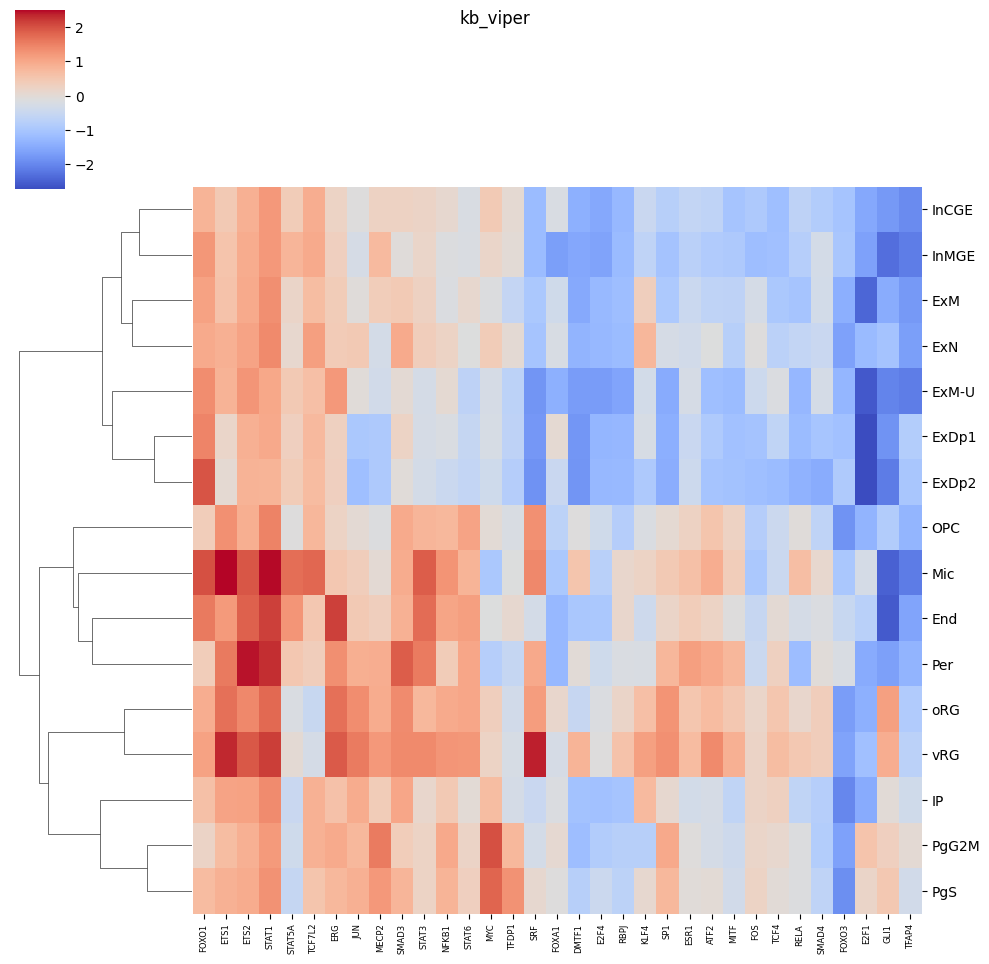

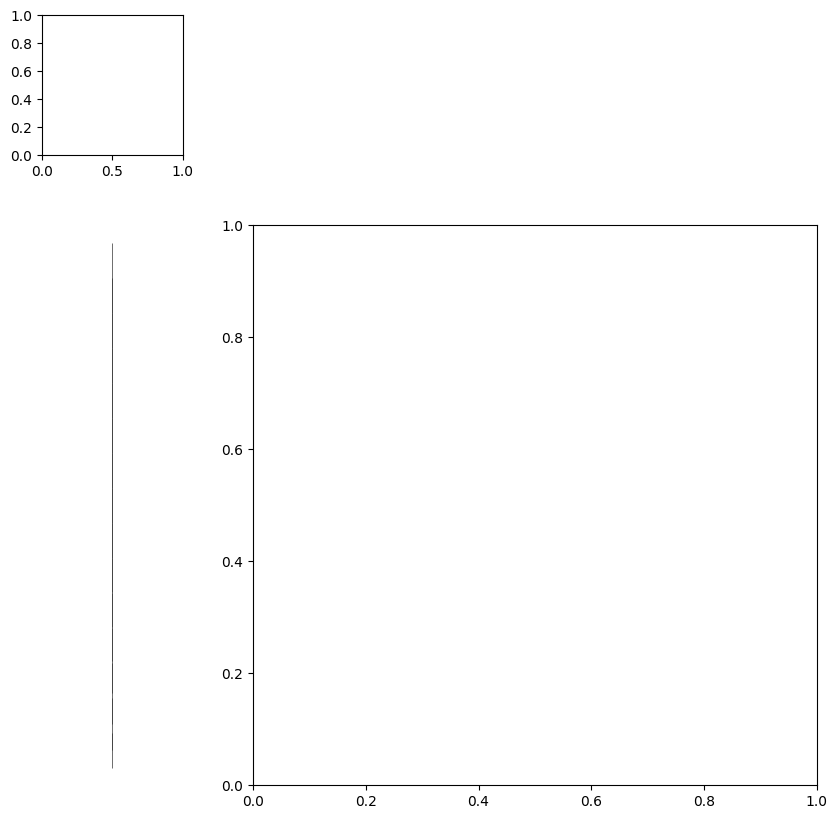

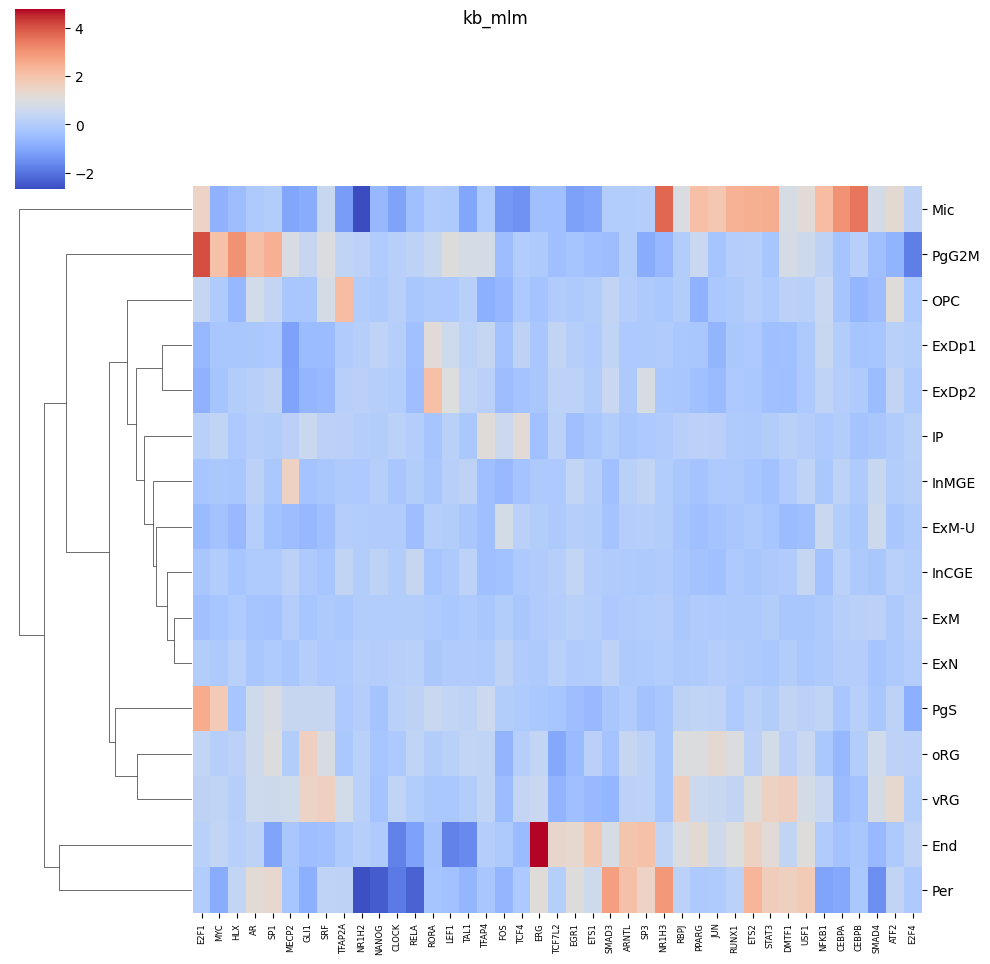

In [84]:
for elem in ['kb_viper_estimate', 'kb_aucell_estimate', 'kb_mlm_estimate']:
    acts = dc.get_acts(adata, obsm_key=elem)
    mean_acts = dc.summarize_acts(acts, groupby='Cluster', min_std=0.5)
    try:
        g = sns.clustermap(mean_acts, xticklabels=mean_acts.columns, cmap='coolwarm')
        plt.suptitle('_'.join(elem.split('_')[:2]))
        g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
        g.ax_col_dendrogram.set_visible(False)
    except ValueError:
        print(elem, "cannot be aggregated around its mean/median", sep = " ")

### Are the Fetal Brain relevant TFs found active by the TF activity estimation methods?

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


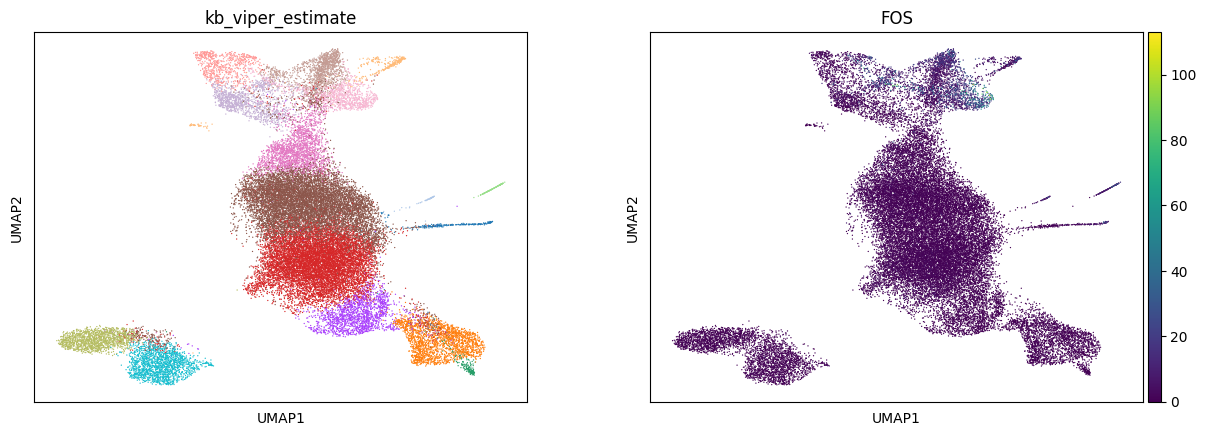

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


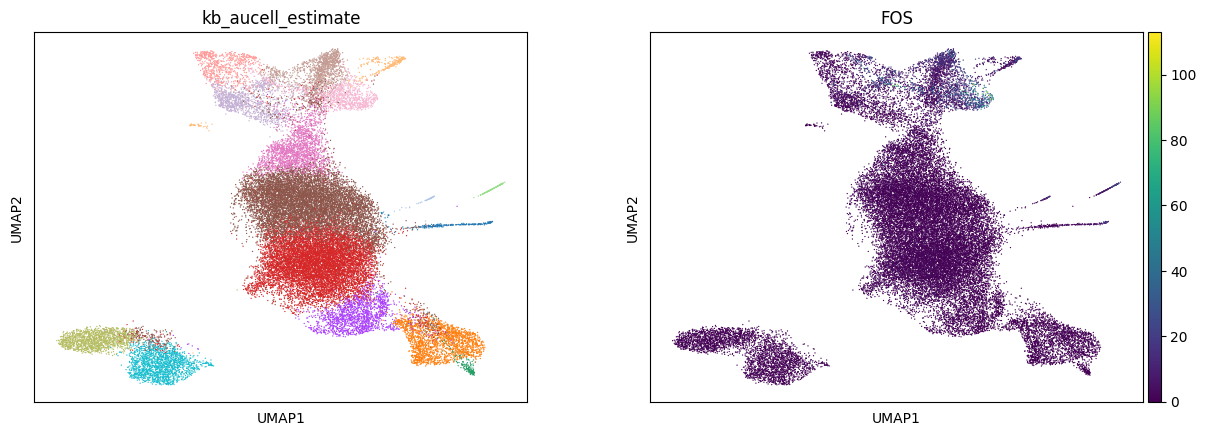

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


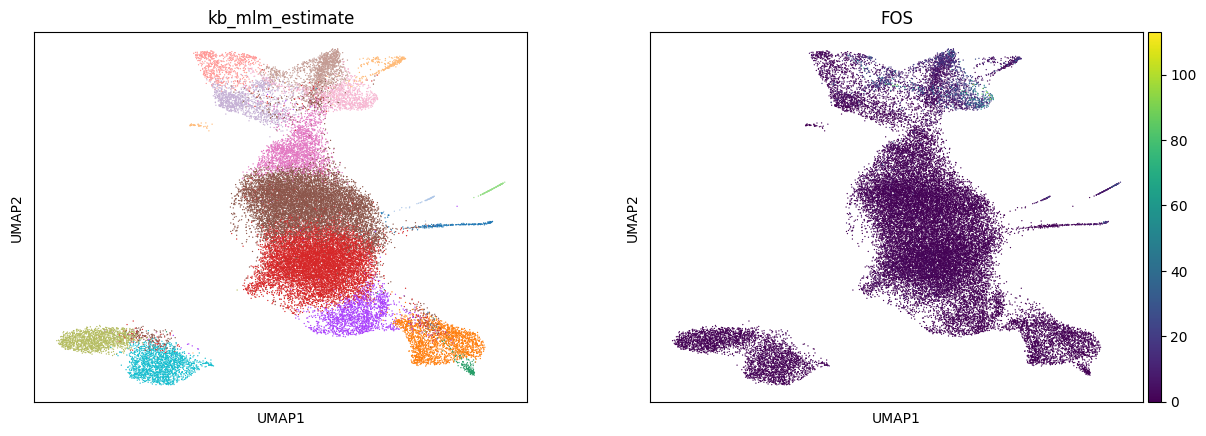

In [87]:
for elem in ['kb_viper_estimate', 'kb_aucell_estimate', 'kb_mlm_estimate']:
    intersection = list(set(adata.obsm[elem]) & set(fetal_brain_tfs['TF']))
    sc.pl.umap(adata, color=['Cluster'] + intersection, legend_loc= 'on_data', title = elem)


### Conclusions
- what are the conclusion we can draw from these data?
- **Optional** Can we use the TF Activity to re-cluster the cells (e.g. do a umap based on TF Activities?)

## TF Activity using an Inferred GRN

We now reload a GRN computed with [GRNBoost2]() and filtered using RcisTargets from the pyscenic pipeline. Let's first load and explore the GRN:

In [89]:
scenic_grn = pd.read_csv(os.path.join(data_dir, 'Pulioudakis_grnboost2.csv'), sep = ",")
scenic_grn.head()
scenic_grn['importance'].min()
scenic_grn['importance'].max()

TF target  importance
0  HMGB2   TPX2  622.766479
1  HMGB2  MKI67  573.982622
2  HMGB2  TOP2A  566.146464
3  HMGB2  PTTG1  541.166360
4  HMGB2  CENPF  488.146652

3.447070806426261e-17

622.7664792273382

We can see that, contrary to the knowledge base, the *importance* (a.k.a. the weight of the interaction is never negative)

GRN Inference method cannot captire inhibition, they can only infer if a TF can be directly associated to a target.else

Also, bear in mind thet **the importance score is just a ranking**, **it does not** represent a signficance and must be carefully considered when removing edges (is it kind of a work of art). It can be however used as a weight for TF Activity methods

Finally: consider that this GRN has been inferred oinly once. If we want to improve our results, it is recommended to run the GRN Ingerence algorithm st least 100 times, changing seed every time,, and then make a consesus network across all inferred GRNs. Of course, this takes a lot of times, and th bigger the dataset the bigger are the resources required. 

A turnaround is to usually infer GRNs only for highly expressed TFs in your dataset, this lowers the number of regression trees of several folds. However, you might lose the signal for lowly epxressed TFs that might be relevant in your case study.

Consider also thart the GRN Inferred-network is a 'blob' where some TFs binds the majority of the network. In this case, VIPER pleiotropy correction can take a lot of time (hours). So for the sake of time, we don't use VIPER in this case

Let's proceed with the TF Activity with this toy GRN: again, we reparse our GRN to make it decoupler-compliant

In [95]:
scenic_grn.columns = ['source', 'target', 'weight']
scenic_grn.head()

source target      weight
0  HMGB2   TPX2  622.766479
1  HMGB2  MKI67  573.982622
2  HMGB2  TOP2A  566.146464
3  HMGB2  PTTG1  541.166360
4  HMGB2  CENPF  488.146652

And compute the TF Activity for this dataset (this will take a little bit longer since the network is bigger, you can grab a coffee if you want :) )

In [94]:
adata = run_decoupler(adata, regulons = scenic_grn, reg_type='scenic', methods=['aucell', 'mlm'])

Running AUCell
Running aucell on mat with 33976 samples and 3851 targets for 335 sources.
Running MLM
Running mlm on mat with 33976 samples and 3851 targets for 335 sources.


100%|██████████| 4/4 [00:18<00:00,  4.69s/it]


done


/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


scenic_aucell_estimate cannot be aggregated around its mean/median


Text(0.5, 0.98, 'scenic_mlm')

[Text(0.5, 0, 'HMGB2'),
 Text(1.5, 0, 'OLIG1'),
 Text(2.5, 0, 'OLIG2'),
 Text(3.5, 0, 'LMO2'),
 Text(4.5, 0, 'ETS2'),
 Text(5.5, 0, 'RBMS1'),
 Text(6.5, 0, 'JUNB'),
 Text(7.5, 0, 'EGR3'),
 Text(8.5, 0, 'ELK3'),
 Text(9.5, 0, 'NR4A1'),
 Text(10.5, 0, 'BRCA1'),
 Text(11.5, 0, 'TCF4'),
 Text(12.5, 0, 'CELF4'),
 Text(13.5, 0, 'NR4A2'),
 Text(14.5, 0, 'ETV1'),
 Text(15.5, 0, 'ZEB1'),
 Text(16.5, 0, 'BDP1'),
 Text(17.5, 0, 'SOX5'),
 Text(18.5, 0, 'LEF1'),
 Text(19.5, 0, 'ZIC1'),
 Text(20.5, 0, 'ETS1'),
 Text(21.5, 0, 'EPAS1'),
 Text(22.5, 0, 'FOXC1'),
 Text(23.5, 0, 'FOXS1'),
 Text(24.5, 0, 'EBF1'),
 Text(25.5, 0, 'PRRX1'),
 Text(26.5, 0, 'NFIB'),
 Text(27.5, 0, 'MAF'),
 Text(28.5, 0, 'GLI3'),
 Text(29.5, 0, 'SOX9'),
 Text(30.5, 0, 'LCORL'),
 Text(31.5, 0, 'NFIA'),
 Text(32.5, 0, 'EOMES'),
 Text(33.5, 0, 'ID1'),
 Text(34.5, 0, 'TGIF2'),
 Text(35.5, 0, 'ERG'),
 Text(36.5, 0, 'MEF2C'),
 Text(37.5, 0, 'FOS'),
 Text(38.5, 0, 'ANXA1'),
 Text(39.5, 0, 'EGR1')]

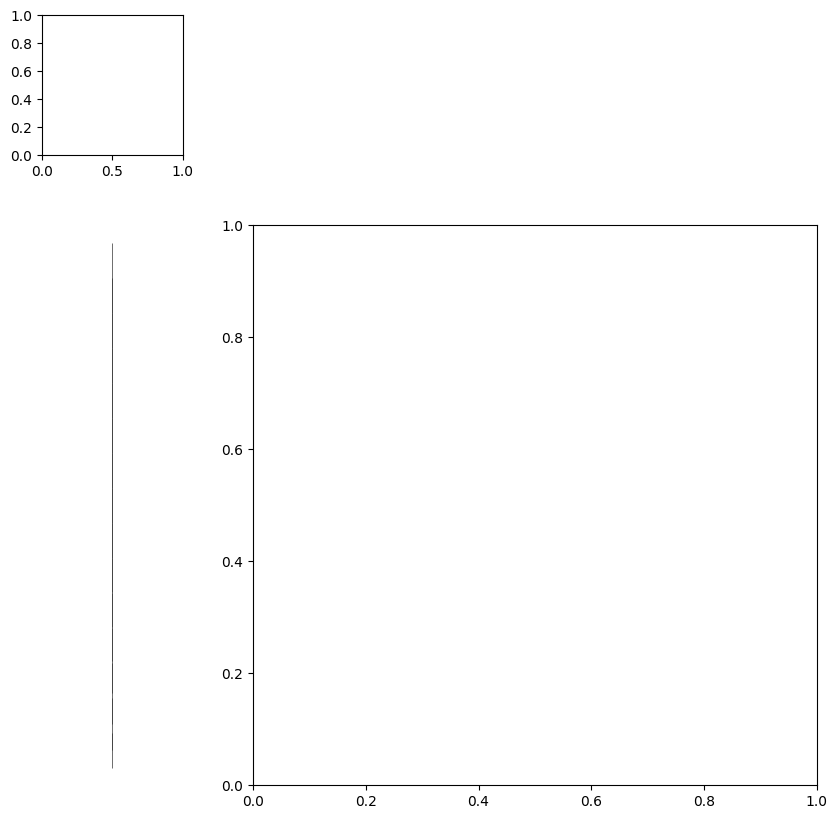

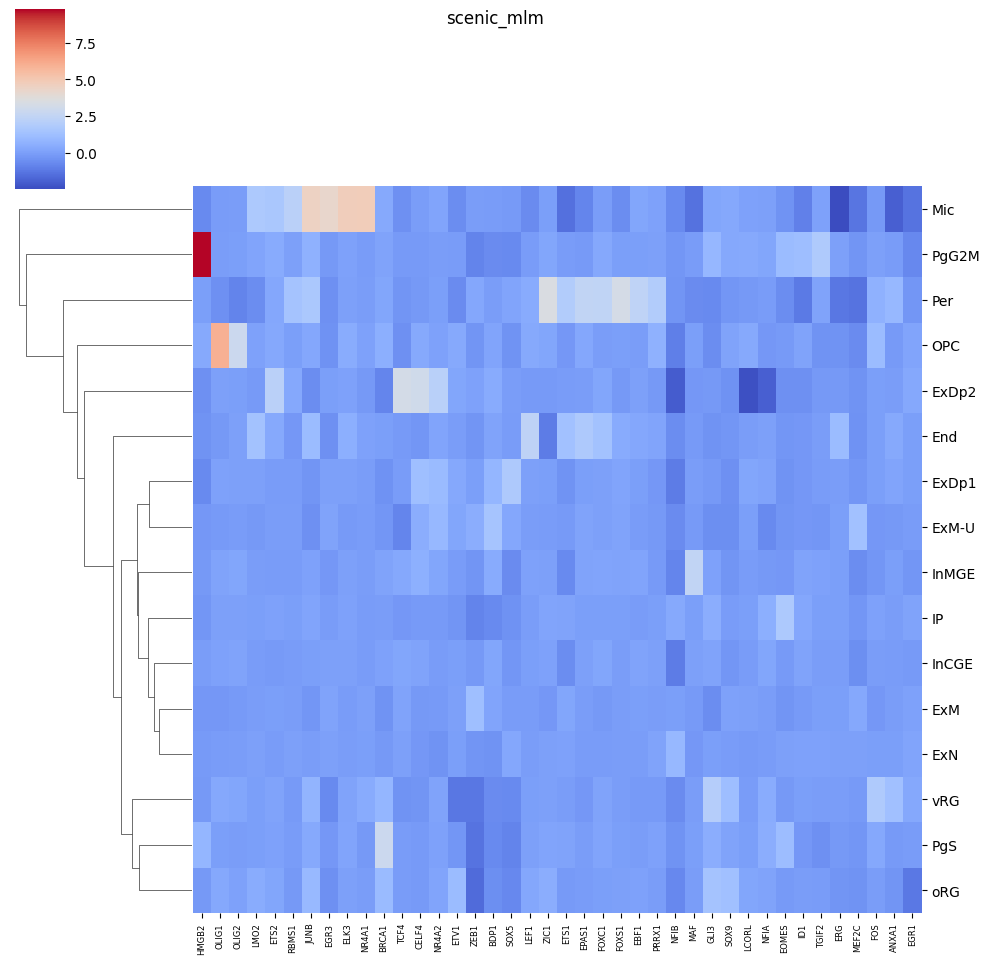

In [105]:
for elem in ['scenic_aucell_estimate', 'scenic_mlm_estimate']:
    acts = dc.get_acts(adata, obsm_key=elem)
    mean_acts = dc.summarize_acts(acts, groupby='Cluster', min_std=0.5)
    try:
        g = sns.clustermap(mean_acts, xticklabels=mean_acts.columns, cmap='coolwarm')
        plt.suptitle('_'.join(elem.split('_')[:2]))
        g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 6)
        g.ax_col_dendrogram.set_visible(False)
    except ValueError:
        print(elem, "cannot be aggregated around its mean/median", sep = " ")

### What is the situation for our Fetal Brain Relevant regulons?


/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


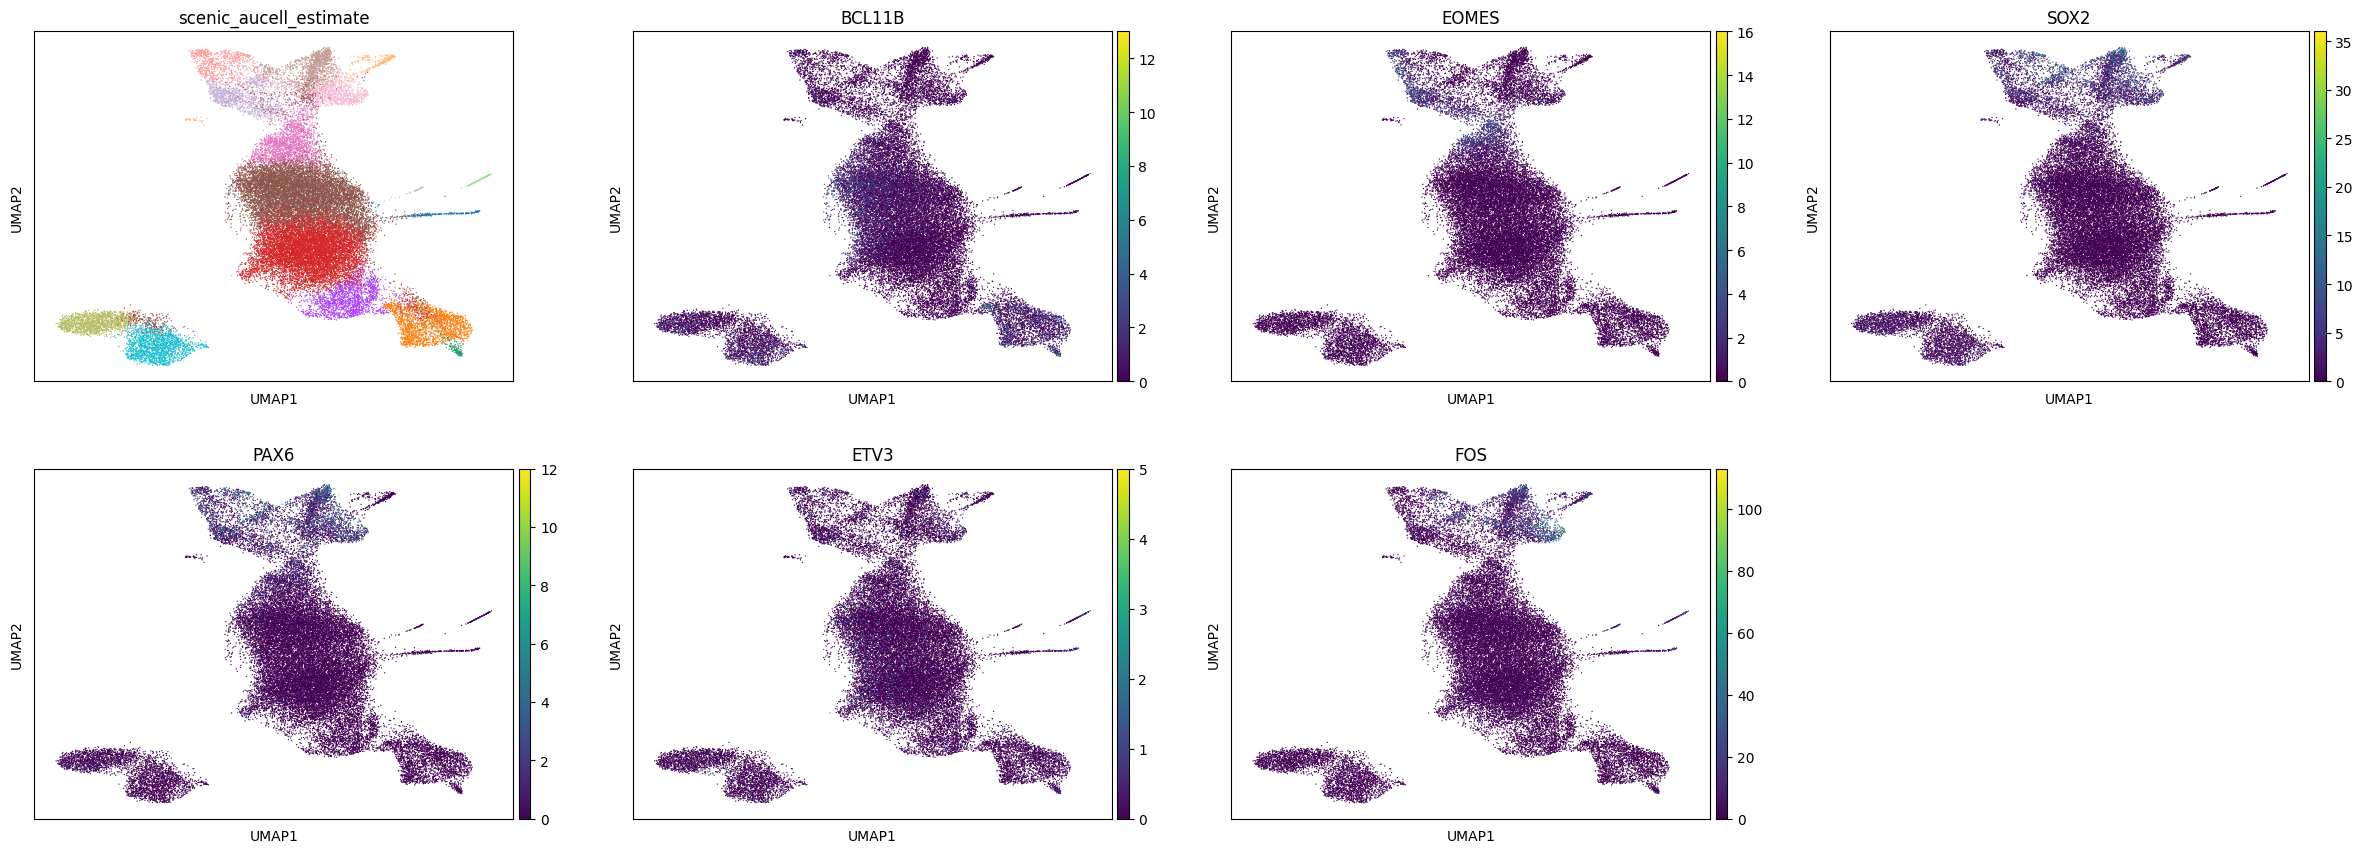

/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


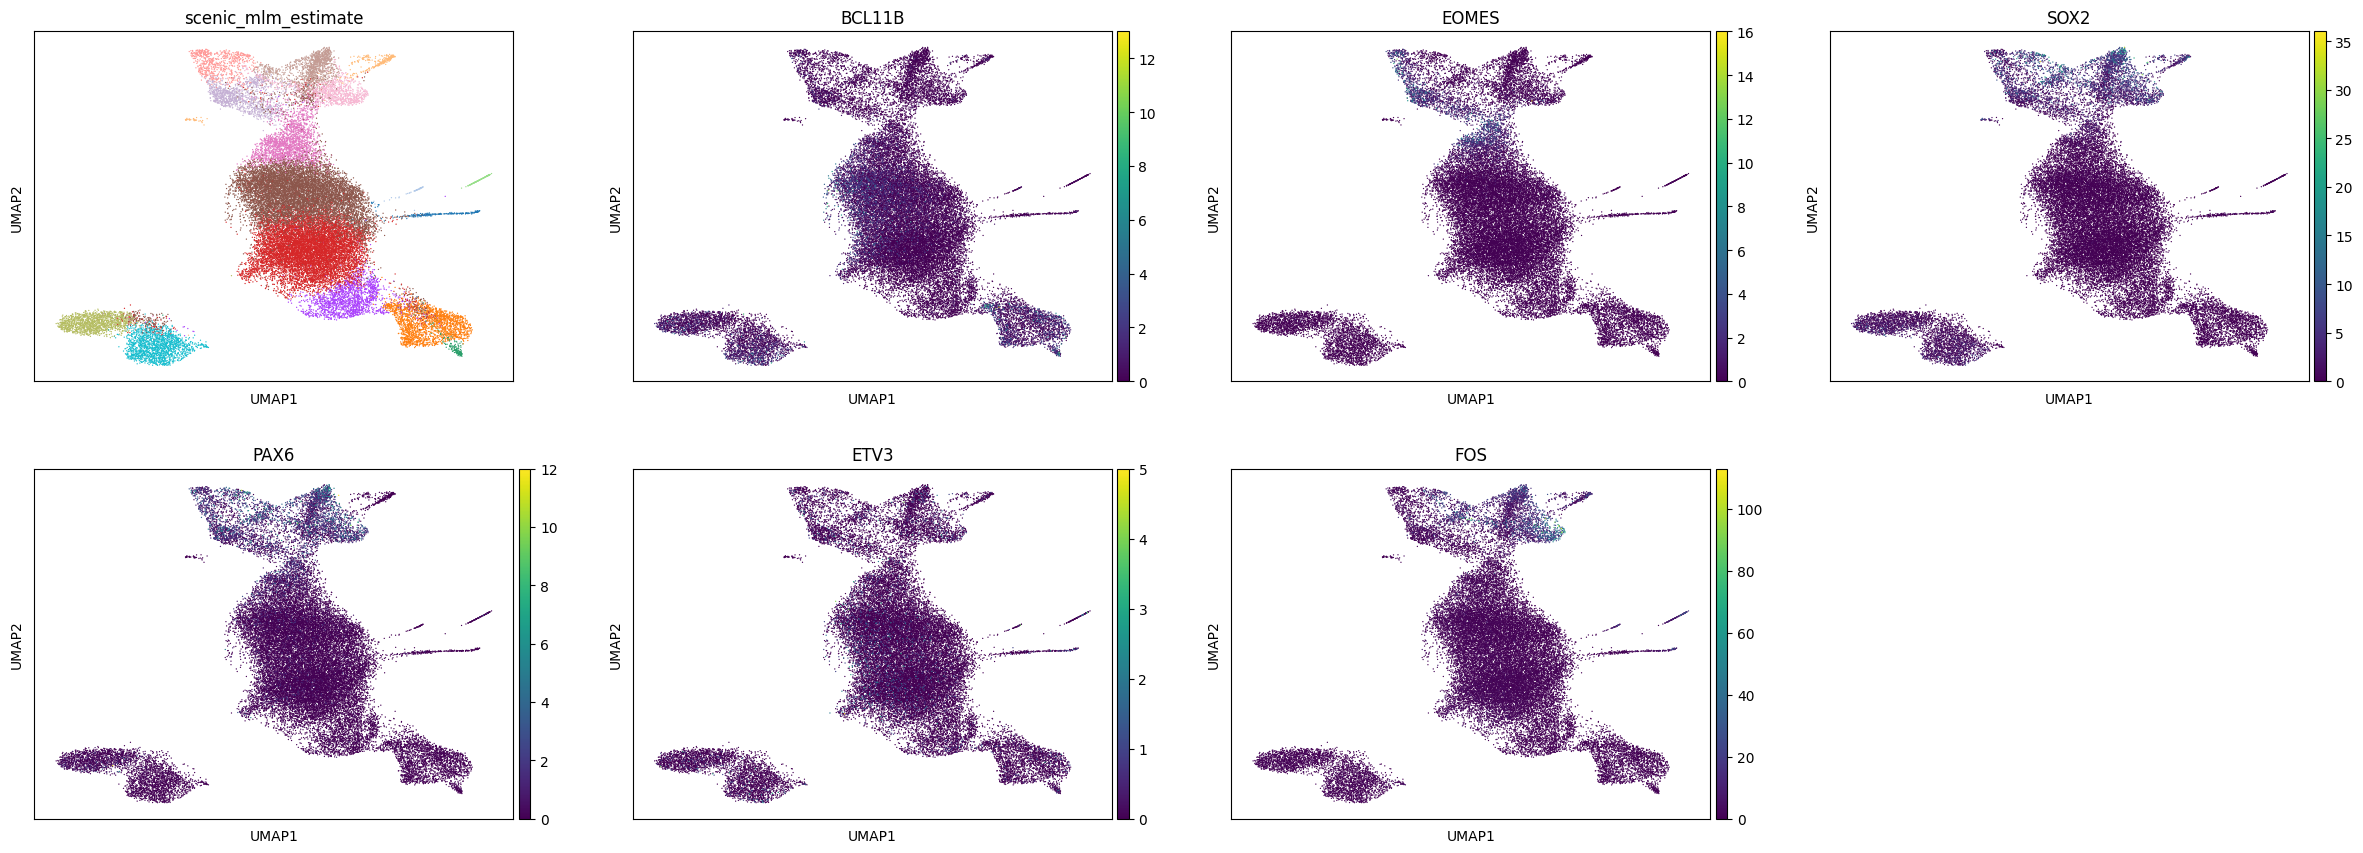

In [106]:
for elem in ['scenic_aucell_estimate', 'scenic_mlm_estimate']:
    intersection = list(set(adata.obsm[elem]) & set(fetal_brain_tfs['TF']))
    sc.pl.umap(adata, color=['Cluster'] + intersection, legend_loc= 'on_data', title = elem)


###  Conclusions

What conclusions can you draw from this?

## Optional: redo TF Activity on Trujillo Dataset


In [107]:
adata = sc.read_h5ad(os.path.join(data_dir, 'Trujillo_2019.h5ad'))
adata


AnnData object with n_obs × n_vars = 16086 × 20651
    obs: 'stage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log_pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'n_genes', 'leiden_1.0', 'leiden_1.4', 'celltype0', 'celltype', 'celltype2', 'celltype3'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype2_colors', 'celltype3_colors', 'celltype_colors', 'dendrogram_celltype', 'dendrogram_leiden_1.4', 'diffmap_evals', 'hvg', 'leiden', 'leiden_1.0_colors', 'leiden_1.4_colors', 'neighbors', 'pca', 'phase_colors', 'stage_colors', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectiviti

stage  n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGAATTGTG-1_1month  1month               2431                 7.796469   
AAACCTGAGCAACGGT-1_1month  1month               2470                 7.812378   
AAACCTGGTGCCTTGG-1_1month  1month               3458                 8.148735   
AAACCTGTCCACTGGG-1_1month  1month               2055                 7.628518   
AAACCTGTCGAACGGA-1_1month  1month               2395                 7.781556   

                           total_counts  log1p_total_counts  total_counts_mt  \
AAACCTGAGAATTGTG-1_1month        6417.0            8.766862            186.0   
AAACCTGAGCAACGGT-1_1month        8528.0            9.051228            227.0   
AAACCTGGTGCCTTGG-1_1month       11854.0            9.380505            322.0   
AAACCTGTCCACTGGG-1_1month        5321.0            8.579604            143.0   
AAACCTGTCGAACGGA-1_1month        7612.0            8.937613            215.0   

                           log1p_total_counts_mt  pct_counts_mt  \
AAACCTGAGAATTGTG-1_1month               5.231109       2.898551   
AAACCTGAGCAACGGT-1_1month               5.429346       2.661820   
AAACCTGGTGCCTTGG-1_1month               5.777652       2.716383   
AAACCTGTCCACTGGG-1_1month               4.969813       2.687465   
AAACCTGTCGAACGGA-1_1month               5.375278       2.824488   

                           total_counts_ribo  log1p_total_counts_ribo  ...  \
AAACCTGAGAATTGTG-1_1month             1407.0                 7.249926  ...   
AAACCTGAGCAACGGT-1_1month             2291.0                 7.737180  ...   
AAACCTGGTGCCTTGG-1_1month             2605.0                 7.865572  ...   
AAACCTGTCCACTGGG-1_1month             1380.0                 7.230563  ...   
AAACCTGTCGAACGGA-1_1month             2598.0                 7.862882  ...   

                            S_score  G2M_score  phase  n_genes leiden_1.0  \
AAACCTGAGAATTGTG-1_1month -0.018752   0.448440    G2M     2431         14   
AAACCTGAGCAACGGT-1_1month -1.840982  -0.591513     G1     2470          5   
AAACCTGGTGCCTTGG-1_1month -2.418949   2.145719    G2M     3458          9   
AAACCTGTCCACTGGG-1_1month -0.378362  -0.307688     G1     2055          3   
AAACCTGTCGAACGGA-1_1month -0.861831  -0.578987     G1     2395          3   

                           leiden_1.4 celltype0 celltype celltype2  \
AAACCTGAGAATTGTG-1_1month          18        NA     Prog      Prog   
AAACCTGAGCAACGGT-1_1month           3    Prog_3     Prog      Prog   
AAACCTGGTGCCTTGG-1_1month           4      MC_4     Prog        MC   
AAACCTGTCCACTGGG-1_1month           0    Prog_0     Prog      Prog   
AAACCTGTCGAACGGA-1_1month           0    Prog_0     Prog      Prog   

                             celltype3  
AAACCTGAGAATTGTG-1_1month  Endothelial  
AAACCTGAGCAACGGT-1_1month           NE  
AAACCTGGTGCCTTGG-1_1month   ApicalProg  
AAACCTGTCCACTGGG-1_1month           NE  
AAACCTGTCGAACGGA-1_1month           NE  

[5 rows x 22 columns]

TF that are present in the dataset:
PAX6	FOS	SOX2	EOMES	ETV2	ETV3	ETV4	BCL11A	BCL11B	CUX1	CUX2


/group/testa/Users/daniele.capocefalo/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


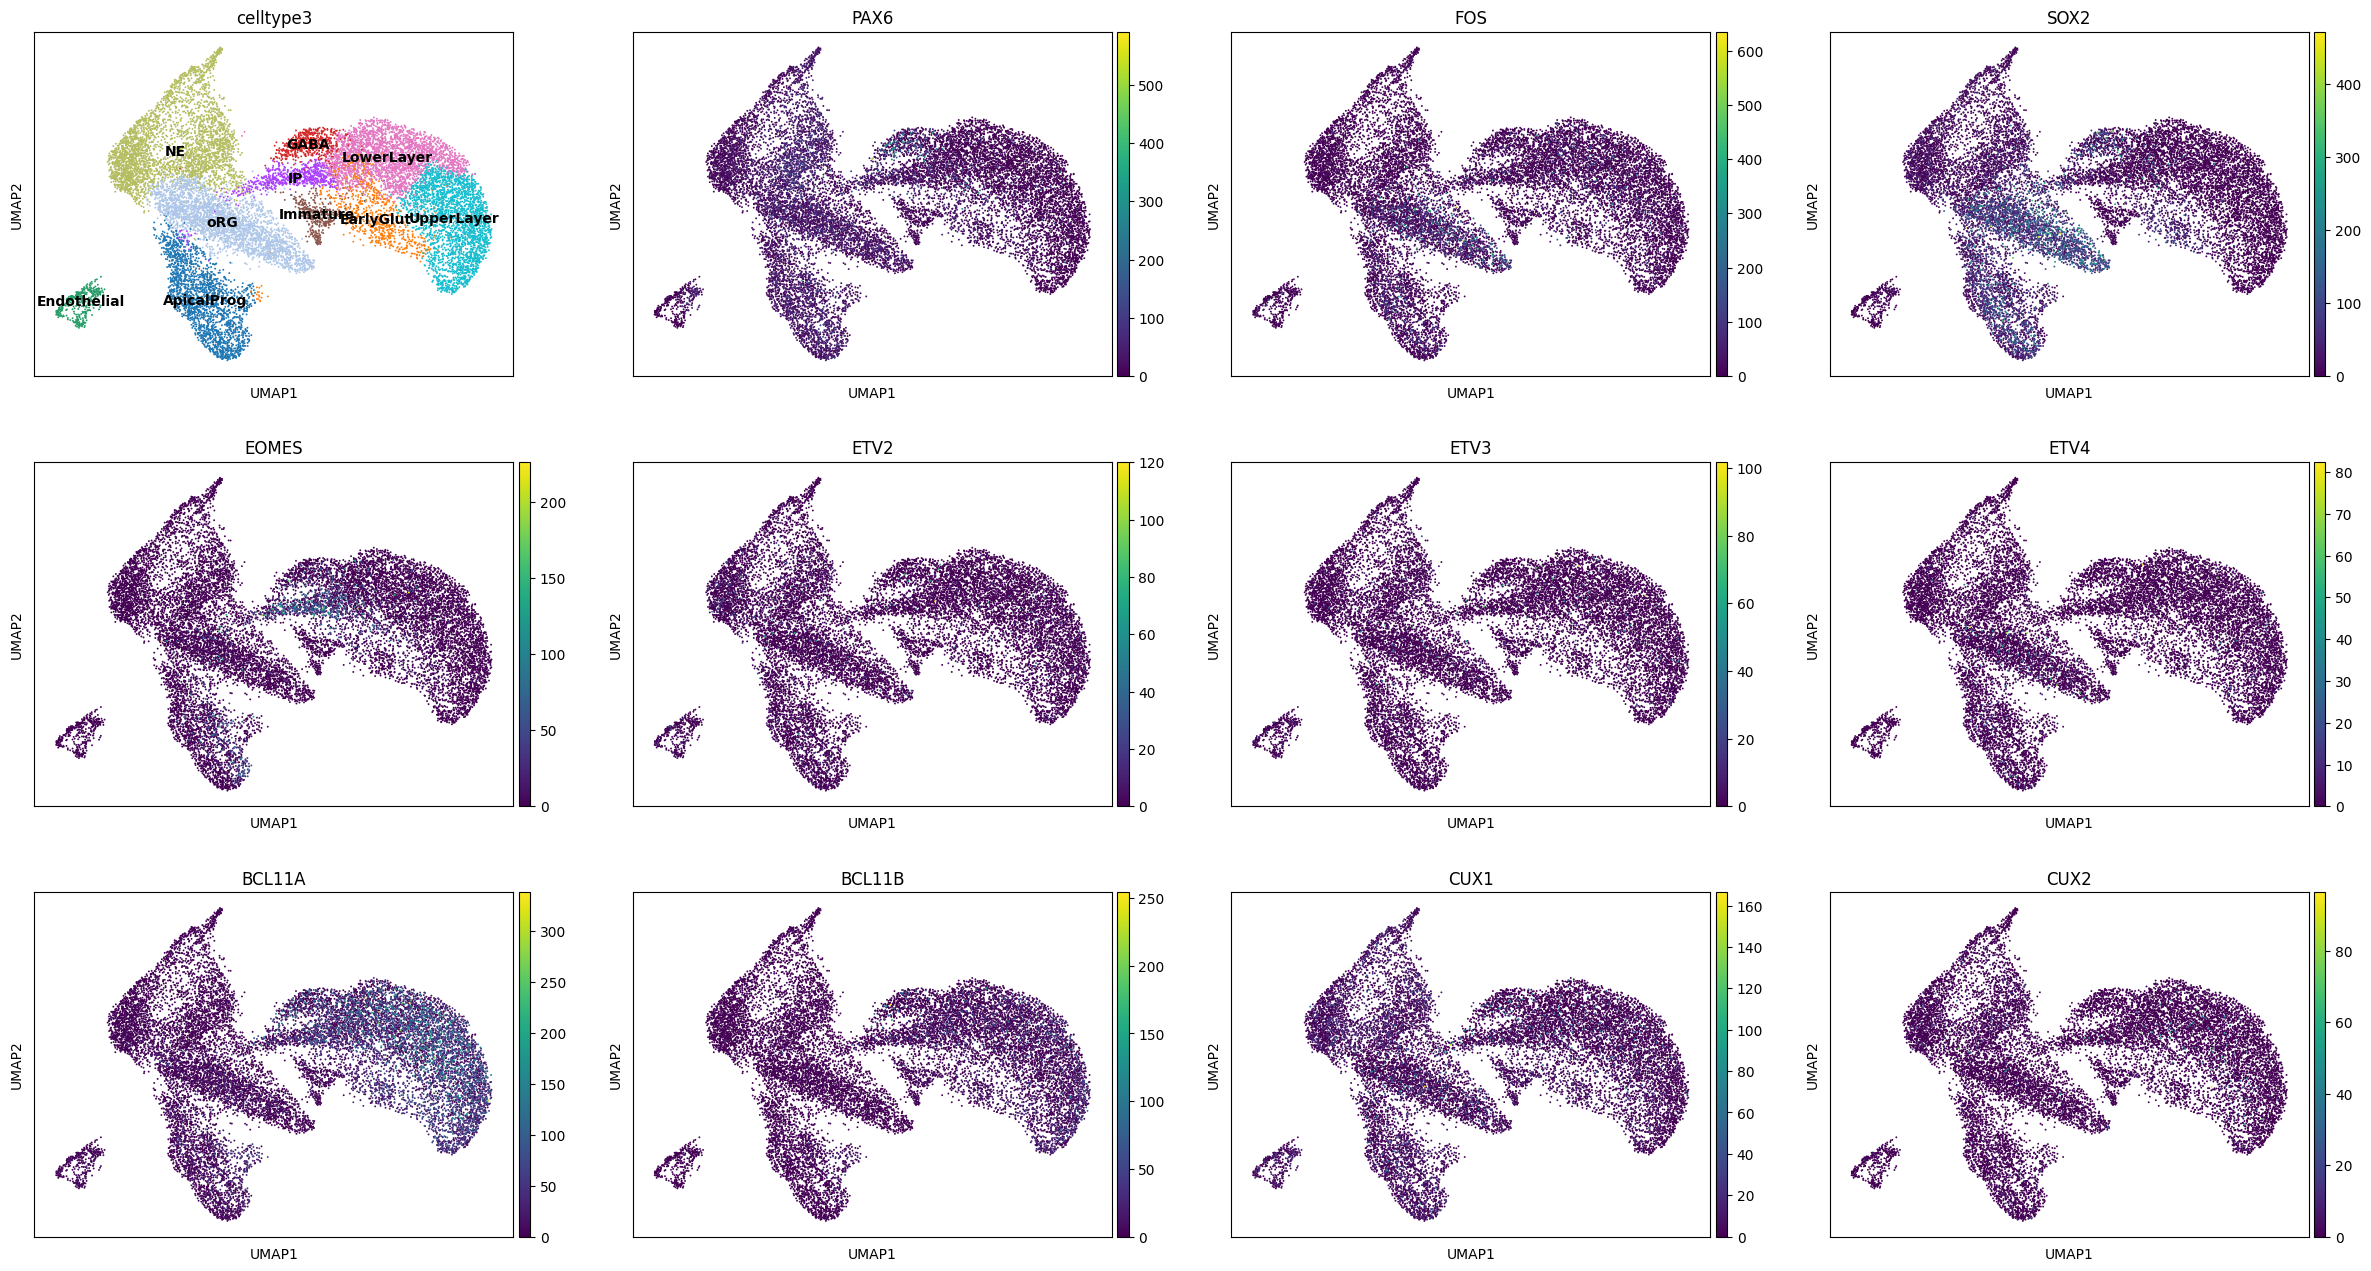

In [109]:
adata.obs.head()

expressed_tfs = [x for x in fetal_brain_tfs['TF'] if x in adata.raw.var_names]
print('TF that are present in the dataset:\n{}'.format('\t'.join(expressed_tfs)))
sc.pl.umap(adata, color = ['celltype3'] + expressed_tfs, legend_loc = 'on data')